In [195]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import csv

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [139]:
data = pd.read_csv('../data/basic_data.csv')
data['log_closePrice'] = np.log(data['closePrice'])

In [141]:
train_data = data[data['date'] < 250]
test_data = data[data['date'] >= 250]

### Cointegrated pairs

In [145]:
## Find Cointegrated pairs of constant+linear regression
colint_stock_list_ct = []

for stock_i in range(50):

    stock_i_df = train_data[train_data['stock'] == stock_i]

    for stock_j in range(stock_i+1, 50):
        
        stock_j_df = train_data[train_data['stock'] == stock_j]

        outcome = coint(stock_i_df['log_closePrice'], stock_j_df['log_closePrice'], trend = 'ct')

        if outcome[1] < 0.05:
            colint_stock_list_ct.append(([stock_i, stock_j], outcome))

### Finding trend

In [148]:
## Calculate the 5 day moving average of the difference in price between the cointegrated pairs 
WINDOW = 5

moving_avg = pd.DataFrame(columns=['stock', 'mid_date', 'avg_price'])

for stock in range(50):
    single_stock = train_data[train_data['stock'] == stock]

    for date in range(250-WINDOW):
        window = single_stock[(single_stock['date'] >= date) & (single_stock['date'] < date+WINDOW)]
        avg_price = window['closePrice'].mean()

        new_row = {'stock': stock, 'mid_date': date+(WINDOW-1)/2, 'avg_price': avg_price}
        moving_avg = pd.concat([moving_avg, pd.DataFrame([new_row])], ignore_index=True)

In [149]:
## Use a linear regression to calculate the slope and intercept (trend) of the 5 day moving average of price differences.
trend_moving_avg = pd.DataFrame(columns=['Pair', 'Slope', 'intercept'])

for ([stock_i, stock_j], outcome) in colint_stock_list_ct:
    stock_i_df = moving_avg[moving_avg['stock'] == stock_i]
    stock_j_df = moving_avg[moving_avg['stock'] == stock_j]

    # Price difference df
    diff = pd.DataFrame()
    diff['difference'] = (stock_i_df['avg_price'].reset_index() - stock_j_df['avg_price'].reset_index())['avg_price']
    diff = np.array(diff['difference']).reshape(-1, 1)
    date = np.array(stock_i_df['mid_date']).reshape(-1, 1)
    
    # Fit linear regression
    LR = LinearRegression(n_jobs=-1).fit(date, diff)

    # Append new data
    new_data = {
        'Pair': [(stock_i, stock_j)],
        'Slope': [LR.coef_],
        'intercept': [LR.intercept_]
    }
    new_df = pd.DataFrame(new_data)
    trend_moving_avg = pd.concat([trend_moving_avg, new_df], ignore_index=True)

### Final Selection of detrended pairs

In [190]:
selected_pairs = pd.DataFrame(columns=["Pair", "LinearSlope", "LinearIntercept", "StandardDeviation"])

for ([stock_i, stock_j], outcome) in colint_stock_list_ct:
    stock_i_df = data[data['stock'] == stock_i]
    stock_j_df = data[data['stock'] == stock_j]
    trend_slope = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["Slope"])
    trend_intercept = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["intercept"])
    
    # detrend the difference in prices using the linear regression results
    diff = (stock_i_df['closePrice'].reset_index() - stock_j_df['closePrice'].reset_index())["closePrice"]
    dates = np.linspace(0,len(stock_i_df)-1, len(stock_i_df))
    trend = trend_slope*dates + trend_intercept
    diff = diff-trend
    
    # Use the augemented dickey-fuller test to filter the pairs with stationary detrended price differences for trading. append to selected pairs.
    adf = adfuller(diff, regression="ct")
    if adf[1] <= 0.05:
        new_data = {
            'Pair' : [(stock_i, stock_j)],
            'LinearSlope' : [trend_slope],
            'LinearIntercept' : [trend_intercept],
            'StandardDeviation' : [np.std(diff)]
        }
        print(stock_i, stock_j)      
        # plt.plot(dates,diff)
        # plt.show()
        new_df = pd.DataFrame(new_data)
        selected_pairs = pd.concat([selected_pairs, new_df], ignore_index=True)
    


/var/folders/wg/4hlcszls02vfyr1nhwtnm3q40000gn/T/ipykernel_703/1911932333.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_slope = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["Slope"])
/var/folders/wg/4hlcszls02vfyr1nhwtnm3q40000gn/T/ipykernel_703/1911932333.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_intercept = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["intercept"])
/var/folders/wg/4hlcszls02vfyr1nhwtnm3q40000gn/T/ipykernel_703/1911932333.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_slope = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["Slope"])
/var/folders/wg/4hlcszls02vfyr1nhwt

13 18


/var/folders/wg/4hlcszls02vfyr1nhwtnm3q40000gn/T/ipykernel_703/1911932333.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_slope = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["Slope"])
/var/folders/wg/4hlcszls02vfyr1nhwtnm3q40000gn/T/ipykernel_703/1911932333.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_intercept = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["intercept"])
/var/folders/wg/4hlcszls02vfyr1nhwtnm3q40000gn/T/ipykernel_703/1911932333.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trend_slope = float(trend_moving_avg[trend_moving_avg["Pair"] == (stock_i,stock_j)]["Slope"])
/var/folders/wg/4hlcszls02vfyr1nhwt

In [150]:
selected_pairs

,Pair,LinearSlope,LinearIntercept,StandardDeviation
0,"(16, 39)",0.036343,-11.851669,2.144328
1,"(18, 23)",-0.010807,35.541849,1.347032
2,"(18, 30)",-0.011116,26.519588,1.141993
3,"(18, 34)",-0.007573,44.920821,1.182922
4,"(18, 42)",-0.000912,15.514760,1.052217
5,"(18, 48)",-0.000855,35.978264,1.094378
6,"(18, 49)",-0.019476,18.627155,1.353149
7,"(22, 25)",-0.019459,0.281132,1.181038
8,"(25, 35)",0.009104,1.904878,0.841683


In [193]:
#!/usr/bin/env python
nInst=50
currentPos = np.zeros(nInst)
def getMyPosition (prcSoFar):
     global currentPos
     nInst, nt = prcSoFar.shape
     currentPrices = prcSoFar[:,nt-1] # price of last day
     # For selected pairs, calculate the price difference on the last day
     currentDiff = []
     for index, row in selected_pairs.iterrows():
          pair, slope, intercept, sd = row
          stock_i, stock_j = pair
          currdiff = currentPrices[stock_i] - currentPrices[stock_j] # close price difference
          currtrend = slope*nt + intercept # linear trend predicted using historical data
          currentDiff.append(currdiff - currtrend) # spread = price difference - predicted trend
     
     C = currentDiff/selected_pairs["StandardDeviation"] # divide the spread by the historical standard deviation
     
     # Set an upper bound of 1.5 and lower bound of -1.5 standard deviations. Similar to a threshold.
     Cstar = [] 
     for c in C:
          if c >= 1.5:
               Cstar.append(1.5)
          elif c <= -1.5:
               Cstar.append(-1.5)
          else:
               Cstar.append(c)
     Cstar = np.array(Cstar)
     
     # Use Cstar to calculate the principal denoted to a given pair, using a selected kernal function. If Cstar is postive, j has a higher price 
     # and i has a lower price -> return positive principal, short i and long j. If Cstar is negative, then return negative principal, long i and short j.
     principal = -(1500)*np.cos((Cstar+1.5)/3*np.pi)
     # principal = 1500*np.tanh(0.8*Cstar)
     # principal = -1500*(32*(Cstar/3)**5)
     
     # make trading decisions.
     for i in range(len(selected_pairs["Pair"])):
          stock_i, stock_j = selected_pairs["Pair"][i]
          principal_ij = principal[i]
          
          currentPos[stock_i] -= np.floor(principal_ij/currentPrices[stock_i])
          currentPos[stock_j] += np.floor(principal_ij/currentPrices[stock_j])
     
     return currentPos
          
     ## Implementations to be made:
     # 1. Improve trend predictions
     # 2. Better selection of principal rather than uniformly 1500
     # 3. Test if transformations are necessary
     # 4. Possibly recalculate pairs after certain days?



### Evaluation

In [194]:
#!/usr/bin/env python

import numpy as np
import pandas as pd


nInst = 0
nt = 0
commRate = 0.0010
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    #df=pd.read_csv(fn, sep='\s+', names=cols, header=None, index_col=0)
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    nt, nInst = df.values.shape
    return (df.values).T

pricesFile="../data/prices.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

currentPos = np.zeros(nInst)

PnL = []
def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_,nt) = prcHist.shape
    for t in range(251,501): 
        prcHistSoFar = prcHist[:,:t]
        newPosOrig = getMyPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:,-1] #prcHist[:,t-1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        clipPos = np.clip(newPosOrig, -posLimits, posLimits)
        newPos = np.array([np.trunc(x) for x in clipPos])
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" % (t,value, todayPL, totDVolume, ret))
        PnL.append(todayPL)
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)



(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print ("=====")
print ("mean(PL): %.1lf" % meanpl)
print ("return: %.5lf" % ret)
print ("StdDev(PL): %.2lf" % plstd)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)
print ("Score: %.2lf" % score)

Loaded 50 instruments for 500 days
Day 251 value: -0.07 todayPL: $-0.07 $-traded: 72 return: -0.00100
Day 252 value: 0.18 todayPL: $0.25 $-traded: 172 return: 0.00103
Day 253 value: -0.19 todayPL: $-0.37 $-traded: 244 return: -0.00079
Day 254 value: 1.30 todayPL: $1.49 $-traded: 874 return: 0.00148
Day 255 value: 1.38 todayPL: $0.08 $-traded: 1434 return: 0.00096
Day 256 value: 2.18 todayPL: $0.81 $-traded: 2407 return: 0.00091
Day 257 value: -8.15 todayPL: $-10.34 $-traded: 2622 return: -0.00311
Day 258 value: 7.61 todayPL: $15.77 $-traded: 4267 return: 0.00178
Day 259 value: 29.82 todayPL: $22.20 $-traded: 7324 return: 0.00407
Day 260 value: 5.17 todayPL: $-24.65 $-traded: 9531 return: 0.00054
Day 261 value: 15.06 todayPL: $9.89 $-traded: 12599 return: 0.00120
Day 262 value: 10.65 todayPL: $-4.41 $-traded: 15603 return: 0.00068
Day 263 value: 25.65 todayPL: $15.00 $-traded: 18662 return: 0.00137
Day 264 value: -31.44 todayPL: $-57.09 $-traded: 19948 return: -0.00158
Day 265 value: -4

In [63]:
PnL

[-395.853609999991]

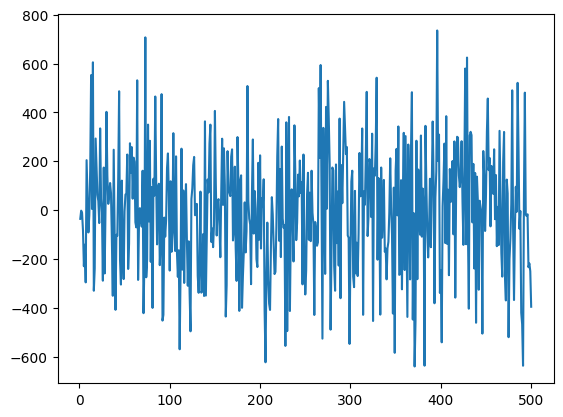

In [66]:
plt.plot(np.linspace(1,500,500), PnL)